## Decision Tree com Grid Search

***Imports***

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier


**1. Leitura e Inspeção dos Datasets**

In [18]:
train_df = pd.read_csv("train_data_prepared.csv", encoding = "latin-1", keep_default_na = False, na_values = ['NULL', ''])
test_df = pd.read_csv("test_data_prepared.csv", encoding = "latin-1", keep_default_na = False, na_values = ['NULL', ''])

***Inspeção dos Dados***

In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6812 entries, 0 to 6811
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   AVERAGE_FREE_FLOW_SPEED  6812 non-null   float64
 1   AVERAGE_TIME_DIFF        6812 non-null   float64
 2   AVERAGE_FREE_FLOW_TIME   6812 non-null   float64
 3   LUMINOSITY               6812 non-null   int64  
 4   AVERAGE_TEMPERATURE      6812 non-null   float64
 5   AVERAGE_ATMOSP_PRESSURE  6812 non-null   float64
 6   AVERAGE_HUMIDITY         6812 non-null   float64
 7   AVERAGE_WIND_SPEED       6812 non-null   float64
 8   AVERAGE_CLOUDINESS       6812 non-null   int64  
 9   RAIN_INTENSITY           6812 non-null   int64  
 10  record_date_year         6812 non-null   int64  
 11  record_date_month        6812 non-null   int64  
 12  record_date_day          6812 non-null   int64  
 13  record_date_hour         6812 non-null   int64  
 14  day_of_week             

In [20]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   AVERAGE_FREE_FLOW_SPEED  1500 non-null   float64
 1   AVERAGE_TIME_DIFF        1500 non-null   float64
 2   AVERAGE_FREE_FLOW_TIME   1500 non-null   float64
 3   LUMINOSITY               1500 non-null   int64  
 4   AVERAGE_TEMPERATURE      1500 non-null   float64
 5   AVERAGE_ATMOSP_PRESSURE  1500 non-null   float64
 6   AVERAGE_HUMIDITY         1500 non-null   float64
 7   AVERAGE_WIND_SPEED       1500 non-null   float64
 8   AVERAGE_CLOUDINESS       1500 non-null   int64  
 9   RAIN_INTENSITY           1500 non-null   int64  
 10  record_date_year         1500 non-null   int64  
 11  record_date_month        1500 non-null   int64  
 12  record_date_day          1500 non-null   int64  
 13  record_date_hour         1500 non-null   int64  
 14  day_of_week             

In [21]:
print("Tamanho do treino:" ,train_df.shape)
print("Tamanho do teste:" ,test_df.shape)

Tamanho do treino: (6812, 33)
Tamanho do teste: (1500, 32)


***Separar as features e target***

In [22]:
X = train_df.drop(columns=["AVERAGE_SPEED_DIFF"])
y = train_df["AVERAGE_SPEED_DIFF"]

***Ver distribuição de classes***

Distribuição de classes:
AVERAGE_SPEED_DIFF
0    2200
2    1651
1    1419
3    1063
4     479
Name: count, dtype: int64

Distribuição percentual (%):
AVERAGE_SPEED_DIFF
0    32.295948
2    24.236641
1    20.830887
3    15.604815
4     7.031709
Name: proportion, dtype: float64


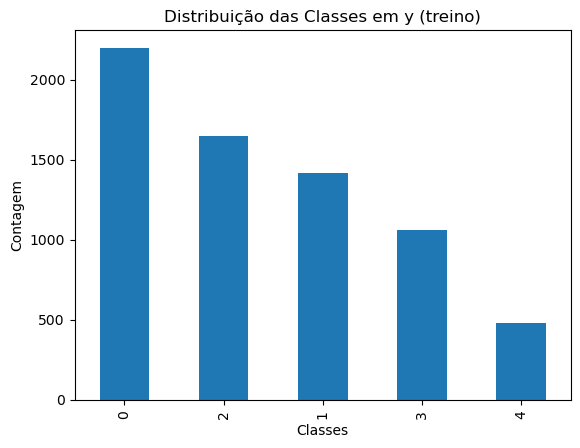

In [23]:
print("Distribuição de classes:")
print(y.value_counts())                 # contagem absoluta das classes

print("\nDistribuição percentual (%):")
print(y.value_counts(normalize=True) * 100)    # contagem percentual das classes

# gráfico da distribuição das classes no conjunto de treino
y.value_counts().plot(kind='bar')
plt.title("Distribuição das Classes em y (treino)")
plt.xlabel("Classes")
plt.ylabel("Contagem")
plt.show()

**2. Treino**

***Treino do Modelo Base***

In [24]:
dt_model = DecisionTreeClassifier(
    random_state=42,
    class_weight="balanced",   # tentar compensar classes desbalanceadas
)


***Definir Grelha de Hiperparâmetros***

In [25]:
param_grid = {
    "max_depth": [None, 5, 10, 20, 30],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 5, 10],
    "criterion": ["gini", "entropy"]
}


In [26]:
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

***Configurar e correr Grid Search***

In [27]:
grid_search = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid,
    scoring="accuracy",    # métrica central da competição
    cv=cv,                  # validação cruzada definida acima
    n_jobs=-1,          # usa todos os cores disponíveis
    verbose=2            # mostra o progresso
)

grid_search.fit(X, y)           # ajusta o modelo com todas as combinações de parâmetros


Fitting 5 folds for each of 160 candidates, totalling 800 fits


,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'criterion': ['gini', 'entropy'], 'max_depth': [None, 5, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'entropy'


In [28]:
print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor accuracy média (CV):", grid_search.best_score_)

best_dt = grid_search.best_estimator_

Melhores parâmetros: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}
Melhor accuracy média (CV): 0.7660029110011495


In [ ]:
# Previsão no test set
y_test_pred = best_dt.predict(test_df)

**3. Análise dos resultados**

***Feature Importance***

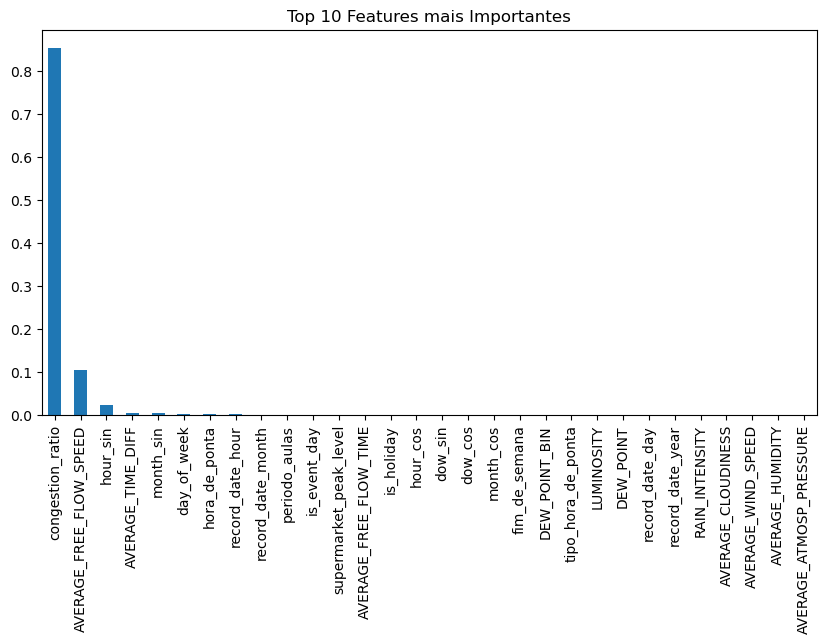

In [30]:
importances = pd.Series(best_dt.feature_importances_, index=X.columns)      # importância das features
importances = importances.sort_values(ascending=False)                      # ordena por importância

plt.figure(figsize=(10, 5))
importances.head(30).plot(kind="bar")                           # features mais relevantes
plt.title("Top 10 Features mais Importantes")
plt.show()

***Mapear classes de volta para o label e gerar o ficheiro de submissão***

In [31]:
reverse_mapping = {
    0: "None",
    1: "Low",
    2: "Medium",
    3: "High",
    4: "Very_High"
}

y_test_labels = pd.Series(y_test_pred).map(reverse_mapping)

submission = pd.DataFrame({
    "RowId": range(1, len(test_df) + 1),
    "Speed_Diff": y_test_labels
})

submission.to_csv("submission.csv", index=False)
print("Ficheiro 'submission.csv' criado com sucesso!")


Ficheiro 'submission.csv' criado com sucesso!


*Accuracy no kaggle: 0.82222*